In [1]:
"""
Import the library to handle the .pkl files associated to the waveform data.
"""

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

libs_path = os.path.abspath(os.path.join("..", "/jupyter-workspace/private/libs"))
if libs_path not in sys.path:
    sys.path.insert(0, libs_path)

import waveform_structure
import reco_structure

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

################## reconstruction data ##################

# version 5.1.   (improve custom cut logic)
# version 5.0    (modified selection logic to accept a configfile)
# version 4.1    (fixed get_scalars method)
# version 4.0    (remove plot and plot_multi methods as they were redudant)
# version 3.2    (added getter for track type)
# version 3.1    (added None mode to extract all data without filters)
# version 3.0    (added setters for single cluster and multicluster selection on redpix data and explained plotting method)
# version 2.0    (rewritten get_sc_variables to return only the variables that passed the selection)
# version 1.4    (added a new get_redpix_real method that does not use the muon mask)
# version 1.3.2  (new clusters are selected based on the smallest ymin and tgausssigma)
# version 1.3.1  (modified the methods added in v 1.2 to use the new selected array)
# version 1.3    (returns also the array of actual selected clusters)
# version 1.2    (added 2 methods to plot which tracks have been have passed the filter)
# version 1.1    (modified muon filters)
# version 1.0

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

class ExtractData:
    def __init__(self, run_number, run_path, waveform=None, mode='muon', config_file="ConfigFile_DataProcess.txt"):
        self.mode = mode
        self.run_number = run_number
        self.run_path = run_path
        self.waveform = waveform
        self.config_params = self._read_config(config_file)
        self.offset_x = self.config_params.get('offset_x', 896.0)
        
        self.data = self._set_data()
        
        if mode == 'muon':
            self._mask = self._muon_filter()
        elif mode == 'iron':
            self._mask = self._iron_filter()
        elif mode == 'custom':
            self._mask = self._custom_filter()
        elif mode is None:
            self._mask = self._no_filter()
        else:
            raise ValueError('Mode must be muon, iron, custom or None')
            
        self.redpix, self._selected = self._set_redpix_all()

    def _read_config(self, config_file):
        params = {}
        try:
            with open(config_file, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split('=')
                        if len(parts) >= 2:
                            key = parts[0].strip()
                            value_str = "=".join(parts[1:]).strip()
                            
                            try:
                                value = float(value_str)
                            except ValueError:
                                value = value_str
                                
                            params[key] = value
        except FileNotFoundError:
            pass
        return params

    def get_type(self):
        return self.mode

    def _set_data(self):
        path = f'{self.run_path}/reco_run{self.run_number:05d}_3D.pkl.gz'
        return pd.read_pickle(path, compression='gzip')

    def _set_redpix_all(self):
        rx = self.data['redpix_ix'].to_numpy() - self.offset_x
        ry = self.data['redpix_iy'].to_numpy()
        rz = self.data['redpix_iz'].to_numpy()
        Id = self.data['sc_redpixIdx'].to_numpy()
    
        redx, redy, redz = [], [], []
        selected = []
    
        for n_image in range(len(Id)):
            cluster_x, cluster_y, cluster_z = [], [], []
            n_clu = len(Id[n_image])
            clu_mask = [False] * n_clu
            
            trigger = True
            if self.waveform is not None:
                if not np.all(self.waveform.booltrigger(n_image)):
                    trigger = False

            if trigger:
                valid_clusters = []
                for cluster in range(n_clu):
                    start_index = int(Id[n_image][cluster])
                    if start_index != -1 and self._mask[n_image][cluster]:
                        valid_clusters.append(cluster)
    
                for c in valid_clusters:
                    clu_mask[c] = True
                    start_index = int(Id[n_image][c])
                    if c < n_clu - 1:
                        end_index = int(Id[n_image][c + 1]) - 1
                    else:
                        end_index = len(rx[n_image])
    
                    cluster_x.append(rx[n_image][start_index:end_index])
                    cluster_y.append(ry[n_image][start_index:end_index])
                    cluster_z.append(rz[n_image][start_index:end_index])
    
            redx.append(cluster_x)
            redy.append(cluster_y)
            redz.append(cluster_z)
            selected.append(clu_mask)
    
        return [redx, redy, redz], selected

    def _muon_filter(self):
        boolean_mask = [( self.data['sc_integral'][n_image]/(self.data['sc_length'][n_image]) >= 8 ) &
                        ( self.data['sc_length'][n_image] > 1000) &
                        ( self.data['sc_tfullrms'][n_image] <= 30) &
                        ( self.data['sc_integral'][n_image]/(self.data['sc_nhits'][n_image]) <= 12)
                        for n_image in range(len(self.data['sc_integral']))]
        return boolean_mask

    def _no_filter(self):
        boolean_mask = [( self.data['sc_integral'][n_image] >= 0 ) 
                        for n_image in range(len(self.data['sc_integral']))]
        return boolean_mask

    def _iron_filter(self):
        boolean_mask = [( self.data['sc_integral'][n_image] <= 4e4 ) &
                        ( self.data['sc_integral'][n_image] >= 1e4) &
                        ( self.data['sc_length'][n_image] < 150) &
                        ( self.data['sc_width'][n_image]/self.data['sc_length'][n_image] <= 1.) &
                        ( self.data['sc_width'][n_image]/self.data['sc_length'][n_image] >= 0.7)
                        for n_image in range(len(self.data['sc_integral']))]
        return boolean_mask

    def _custom_filter(self):
        n_images = len(self.data['sc_integral'])
        mask_list = []
        
        cut_expressions = [val for key, val in self.config_params.items() if key.startswith('cut_')]
        
        sc_columns = [col for col in self.data.columns if col.startswith('sc_')]

        for n_image in range(n_images):
            context = {col: self.data[col][n_image] for col in sc_columns}
            context['np'] = np

            n_clusters = len(context['sc_integral'])
            cluster_mask = np.ones(n_clusters, dtype=bool)

            for expr in cut_expressions:
                try:
                    mask = eval(expr, {"__builtins__": None}, context)
                    cluster_mask &= mask
                except Exception as e:
                    print(f"Error evaluating cut '{expr}' in image {n_image}: {e}")
            
            mask_list.append(cluster_mask)
            
        return mask_list

    def get_sc_data(self):
        key_vec = ['sc_integral', 'sc_width', 'sc_length', 'sc_tfullrms', 'sc_lfullrms', 'sc_nhits']
        val_vec = []
        for key in key_vec:
            temp = self._scalar_iterator(key)
            val_vec.append(temp)
            
        out_dict = {key:val for key, val in zip(key_vec, val_vec)}
        return out_dict

    def _scalar_iterator(self, key):
        temp = self.data[key].to_numpy()
        t_im_struct = []
        for image_idx in range(len(temp)):
            t_clu_struct = []
            n_clu = len(temp[image_idx])
            for clu_idx in range(n_clu):
                if self._selected[image_idx][clu_idx]:
                    t_clu_struct.append(temp[image_idx][clu_idx])
            t_im_struct.append(t_clu_struct)
        return t_im_struct

    def get_raw_data(self):
        return self.data

    def get_redpix(self):
        return self.redpix

    def get_nclu(self):
        return [len(clu) for clu in self.redpix[0]] 

    def plot_filtered_images(self, n_start, n_end):
        for image in range(n_start, n_end):
            trigger = True
            if self.waveform is not None:
                if not np.all(self.waveform.booltrigger(image)):
                    trigger = False
            
            if trigger:
                image_muons = np.full((2304, 2304), np.nan)
                image_others = np.full((2304, 2304), np.nan)

                for clu in range( len(self.data['sc_redpixIdx'][image]) - 1 ):
                    start = int(self.data['sc_redpixIdx'][image][clu])
                    end   = int(self.data['sc_redpixIdx'][image][clu + 1] - 1)
                    
                    if start != -1:
                        x = self.data['redpix_ix'][image][start:end] - self.offset_x
                        y = self.data['redpix_iy'][image][start:end]
                        z = self.data['redpix_iz'][image][start:end]

                        for xi, yi, zi in zip(x, y, z):
                            if 0 <= xi < 2304 and 0 <= yi < 2304:
                                if self._selected[image][clu]:
                                    image_muons[int(yi), int(xi)] = zi
                                else:
                                    image_others[int(yi), int(xi)] = zi
                fig, ax = plt.subplots(figsize=(6,6))
                im1 = ax.imshow(image_others, cmap='Greys')
                im2 = ax.imshow(image_muons, cmap='jet', vmin=0, vmax=np.nanmax(self.data['redpix_iz'][image]))
                ax.set_xlabel('x [px]')
                ax.set_ylabel('y [px]')
                ax.set_title(f'Image {image}')
                ax.set_xlim(0, 2304)
                ax.set_ylim(0, 2304)
                tick_spacing = 256
                ticks = np.arange(0, 2304 + tick_spacing, tick_spacing)
                ax.set_xticks(ticks)
                ax.set_yticks(ticks)
                ax.grid(linestyle='--', linewidth=0.5)
                
                cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('sc_integral [-]')
                plt.tight_layout()
                plt.show()
            else:
                print(f'Image {image} is not tagged by the PMTs')

    def plot_explained_tracks(self, n_start, n_end):
        for image in range(n_start, n_end):
            trigger = True
            if self.waveform is not None:
                if not np.all(self.waveform.booltrigger(image)):
                    trigger = False
                    
            if trigger:
                fig, ax = plt.subplots(figsize=(6,6))
                for clu in range( len(self.data['sc_redpixIdx'][image]) - 1 ):
                    start = int(self.data['sc_redpixIdx'][image][clu])
                    end   = int(self.data['sc_redpixIdx'][image][clu + 1] - 1)
                    trms = self.data['sc_tfullrms'][image][clu]
                    delta = self.data['sc_integral'][image][clu] / self.data['sc_nhits'][image][clu]

                    if start != -1:
                        x = self.data['redpix_ix'][image][start:end] - self.offset_x
                        y = self.data['redpix_iy'][image][start:end]
                        if self._selected[image][clu]:
                            ax.scatter(x, y, label=f'trms {trms:.1f}, delta {delta:.1f}', s=0.1)
                        else:
                            ax.scatter(x, y, label=f'trms {trms:.1f}, delta {delta:.1f}', s=0.1)
                ax.set_xlim(0, 2304)
                ax.set_ylim(0, 2304)
                ax.set_xlabel('x [px]')
                ax.set_ylabel('y [px]')
                ax.legend(markerscale=12, loc='upper left')
                plt.title(f'Image {image}')
                tick_spacing = 256
                ticks = np.arange(0, 2304 + tick_spacing, tick_spacing)
                ax.set_xticks(ticks)
                ax.set_yticks(ticks)
                ax.grid(linestyle='--', linewidth=0.5)
                
                plt.tight_layout()
                plt.show()
            else:
                print(f'Image {image} is not tagged by the PMTs')

In [3]:
"""
Here how to import the waveform data and initialise the reconstruction data container
"""

run = 13830

wave_path = '/jupyter-workspace/private/run_data/waveforms/'
reco_path = '/jupyter-workspace/private/run_data/reco/'

wave = waveform_structure.SingleWaveform(run, wave_path)

# there are 4 selection modes:
# - 'iron': selects only clusters compatible with iron55 ER
# - 'muon': selects only muon clusters (remember to add a waveform if you want the waveform selection for correct muon tag)
# - 'custom': uses the cuts defined in the ConfigFile
# - None : Applies no filter

reco = ExtractData(run, reco_path, waveform=wave, config_file='ConfigFile_DataProcess.txt', mode='muon') 

Image 0 is not tagged by the PMTs
Image 1 is not tagged by the PMTs


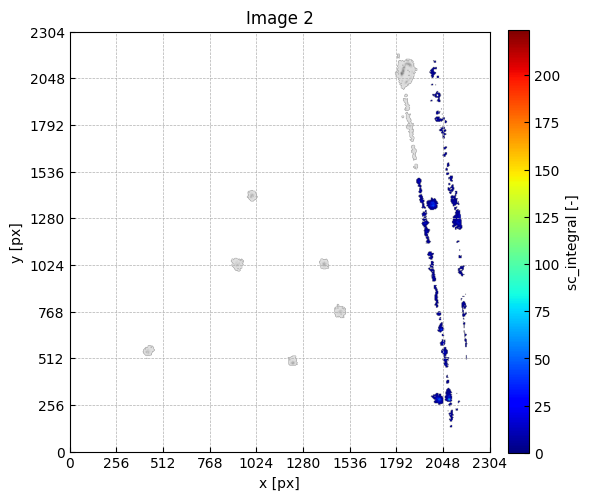

In [4]:
"""
First test the internal methods of the extract data class, they are intended as utilities to help in visualising the
raw data of the reco along with the selected tracks:

plot_filtered_images : takes the index of the first image to plot and the last and plots all in between iff they are tagged

plot_explained_image : plots the images with different colors depending on which cluster they belog to, for each cluster,
the sc_tfullrms and delta of the track are shown.
"""

index_start = 0
index_end = 3

reco.plot_filtered_images(index_start, index_end)
#reco.plot_explained_tracks(index_start, index_end)

Text(0.5, 0, 'Number of selected clusters')

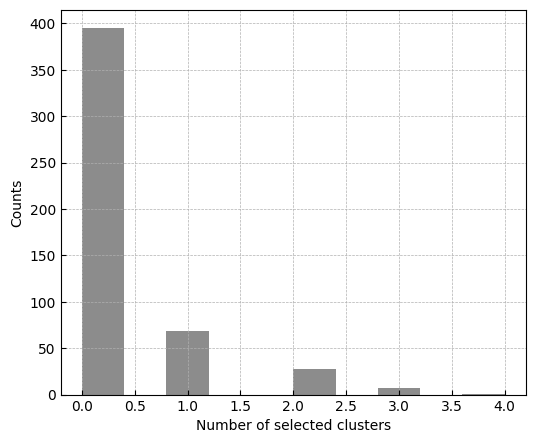

In [5]:
"""
The class also has getter methods from which to extract information regarding the data
"""

# get nclu returns a list with the length equal to the number of images in the run file
# each entry details how many clusters have been selected in that image
nclu = reco.get_nclu()

# and plot the histogram

fig, ax = plt.subplots(figsize=(6,5))
ax.hist(nclu, histtype='stepfilled', color='black', linewidth=1.5, alpha=0.45)
ax.grid(linewidth=0.5, linestyle='--')
ax.set_ylabel('Counts')
ax.set_xlabel('Number of selected clusters')

In [6]:
import numpy as np
import gc

class TrackRestructurer:
    def __init__(self, reco):
        self.reco = reco
        self.data = self._restructure()
        del self.reco
        gc.collect()

    def _restructure(self):
        scalars_dict = self.reco.get_sc_data()
        rx_all, ry_all, rz_all = self.reco.get_redpix()
        
        scalar_keys = list(scalars_dict.keys())
        
        data = []
        n_images = len(rx_all)
        
        for image_idx in range(n_images):
            clusters_x = rx_all[image_idx]
            clusters_y = ry_all[image_idx]
            clusters_z = rz_all[image_idx]
            image_scalars = {key: scalars_dict[key][image_idx] for key in scalar_keys}
            
            n_clu = len(clusters_x)
            
            for clu_idx in range(n_clu):
                track_dict = {
                    'redpix_ix': clusters_x[clu_idx],
                    'redpix_iy': clusters_y[clu_idx],
                    'redpix_iz': clusters_z[clu_idx],
                    'image_idx': image_idx,
                    'cluster_idx': clu_idx
                }
                for key in scalar_keys:
                    track_dict[key] = image_scalars[key][clu_idx]
                    
                data.append(track_dict)
                
        return data

    def get_data(self):
        return self.data

In [7]:
"""
For those types of tracks where a post reconstruction analysis is not necessary, the restructurer class
reshapes the data in such a way as to be compatible with all other codes that analyse track data, such as
the deconvolution codes and the one to construct the images to infer the z coordinate.
"""


sc_data = TrackRestructurer(reco).get_data()

In [8]:
from tqdm import tqdm
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

class TrackAnalyzer:
    def __init__(self, reco):
        self._reco = reco
        self.data = self._dict_maker()

    def get_n_tracks(self):
        return len(self.data)
    
    def _weighted_covariance(self, X, w):
        w = np.asarray(w, dtype=float)
        W = w.sum()
        if W == 0:
            mean = np.average(X, axis=0)
            cov = np.cov(X.T)
            return cov, mean
        mean = (w[:, None] * X).sum(axis=0) / W
        Xc = X - mean
        cov = (w[:, None, None] * (Xc[:, :, None] * Xc[:, None, :])).sum(axis=0) / W
        return cov, mean

    def _weighted_moments(self, vals, w):
        w = np.asarray(w, dtype=float)
        W = w.sum()
        if W == 0:
            return np.mean(vals), np.var(vals), skew(vals), kurtosis(vals)
        mean = (w * vals).sum() / W
        dev = vals - mean
        var = (w * (dev**2)).sum() / W
        if var == 0:
            return mean, var, 0.0, 0.0
        std = np.sqrt(var)
        skew_w = (w * (dev**3)).sum() / (W * std**3)
        kurt_w = (w * (dev**4)).sum() / (W * std**4) - 3.0
        return mean, var, skew_w, kurt_w

    def _eval_new_vars(self, X, Z, image_idx, cluster_idx):
        Z = np.asarray(Z, dtype=float)

        cov, centroid = self._weighted_covariance(X, Z)

        eig_vals, eig_vecs = np.linalg.eig(cov)
        idx = np.argsort(eig_vals)[::-1]
        principal_axis = eig_vecs[:, idx[0]].real
        transverse_axis = eig_vecs[:, idx[1]].real

        val_major = eig_vals[idx[0]]
        val_minor = eig_vals[idx[1]]

        if val_major > 0:
            sc_linearity = 1.0 - (val_minor / val_major)
        else:
            sc_linearity = 0.0

        e_lon = principal_axis / np.linalg.norm(principal_axis)
        e_tra = transverse_axis / np.linalg.norm(transverse_axis)

        sc_theta = np.degrees(np.arctan(e_lon[0] / e_lon[1]))

        X_centered = X - centroid
        proj_lon = X_centered.dot(e_lon)
        proj_tra = X_centered.dot(e_tra)

        tmin_lon = proj_lon.min()
        tmax_lon = proj_lon.max()
        axisLen_lon = float(tmax_lon - tmin_lon)

        tmin_tra = proj_tra.min()
        tmax_tra = proj_tra.max()
        axisLen_tra = float(tmax_tra - tmin_tra)

        binmax_lon = int(axisLen_lon)
        nbins_lon = binmax_lon + 2
        binmax_tra = int(axisLen_tra)
        nbins_tra = binmax_tra + 2

        nbins_lon = max(nbins_lon, 2)
        nbins_tra = max(nbins_tra, 2)

        mapped_lon = proj_lon - tmin_lon
        mapped_tra = proj_tra - tmin_tra

        lon_range_max = float(binmax_lon + 2)
        tra_range_max = float(binmax_tra + 2)

        histl, edges_l = np.histogram(mapped_lon, bins=nbins_lon, range=(0.0, lon_range_max), weights=Z)
        histt, edges_t = np.histogram(mapped_tra, bins=nbins_tra, range=(0.0, tra_range_max), weights=Z)

        length = np.max(edges_l) - np.min(edges_l)
        width = np.max(edges_t) - np.min(edges_t)

        stepl = edges_l[:-1].copy()
        stept = edges_t[:-1].copy()

        tmin_lon = float(proj_lon.min())
        edge_origin = centroid + tmin_lon * e_lon

        _, var_tra, sc_tskewness, sc_tkurtosis = self._weighted_moments(proj_tra, Z)
        sc_tfullrms = float(np.sqrt(var_tra))
        sc_max_residual = float(np.max(np.abs(proj_tra)))

        try:
            coeffs = np.polyfit(X[:,0], X[:,1], 1)
            m = coeffs[0]
            sc_theta_fit = np.degrees(np.arctan(1/m))
        except:
            m = 0.0
            sc_theta_fit = 0.0

        return {
            'image_idx': image_idx,
            'cluster_idx': cluster_idx,
            'sc_length':length,
            'sc_width':width,
            'principal_axis': e_lon,
            'secondary_axis': e_tra,
            'sc_theta': sc_theta,
            'sc_theta_fit':sc_theta_fit,
            'sc_linearity': sc_linearity,
            'sc_max_residual': sc_max_residual,
            'm_fit':m,
            'sc_tskewness': sc_tskewness,
            'sc_tkurtosis': sc_tkurtosis,
            'sc_tfullrms': sc_tfullrms,
            'center_coordinates': centroid,
            'edge_origin':edge_origin,
            'histl': histl.astype(float),
            'stepl': stepl,
            'histt': histt.astype(float),
            'stept': stept,
            'proj_lon': proj_lon,
            'proj_tra': proj_tra,
            'redpix_ix':X[:, 0],
            'redpix_iy':X[:, 1],
            'redpix_iz':Z
        }

    def _dict_maker(self):
        rx, ry, rz = self._reco.get_redpix()
        n_image = len(rx)
        data = []
        for image_idx in range(n_image):
            n_clu = len(rx[image_idx])
            for clu in range(n_clu):
                
                X = np.column_stack([rx[image_idx][clu], ry[image_idx][clu]])
                Z = rz[image_idx][clu]
                data.append( self._eval_new_vars(X, Z, image_idx, clu))
        return data

    def get_data(self):
        return self.data

    def plot(self, index):
        if 0 <= index < len(self.data):
            fig, ax = plt.subplots(1,3, figsize=(18,5))

            trms = self.data[index]['sc_tfullrms']
            skewness = self.data[index]['sc_tskewness']
            kurtosis = self.data[index]['sc_tkurtosis']
            theta = self.data[index]['sc_theta']

            textstr_x = '\n'.join((rf'$\theta$ = {theta:.2f}',
                                   rf'$\sigma$ = {trms:.2f}',
                                   rf'skew = {skewness:.2f}',
                                   rf'kurt = {kurtosis:.2f}',))
            
            image = np.full((2304, 2304), np.nan)
            x = self.data[index]['redpix_ix']
            y = self.data[index]['redpix_iy']
            z = self.data[index]['redpix_iz']
            image[y.astype(int), x.astype(int)] = z

            im = ax[0].imshow(image, cmap='jet')
            ax[0].set_xlabel('x [px]', fontsize=10)
            ax[0].set_ylabel('y [px]', fontsize=10)
            ax[0].grid(True, linestyle='--', linewidth=0.5)
            ax[0].text(0.05, 0.95, textstr_x, fontsize=10,
                    verticalalignment='top',horizontalalignment='left', transform=ax[0].transAxes, 
                    bbox=dict(boxstyle='square', facecolor='white', alpha=1, edgecolor='black'))
            cbar = plt.colorbar(im, ax=ax[0])
            cbar.set_label('pixel intensity [-]', fontsize=10)

            tick_spacing = 256
            ticks = np.arange(0, 2304 + tick_spacing, tick_spacing)
            ax[0].set_xticks(ticks)
            ax[0].set_yticks(ticks)

            ax[1].step(self.data[index]['stepl'], self.data[index]['histl'], color='blue', linewidth=.75)
            ax[1].set_title('Longitudinal histogram', fontsize=10)
            ax[1].set_xlabel('principal axis [px]', fontsize=10)
            ax[1].set_ylabel('counts [-]', fontsize=10)
            ax[1].grid(True, linestyle='--', linewidth=0.5)

            ax[2].step(self.data[index]['stept'], self.data[index]['histt'], color='blue', linewidth=.75)
            ax[2].set_title('Transversal histogram', fontsize=10)
            ax[2].set_xlabel('secondary axis [px]', fontsize=10)
            ax[2].set_ylabel('counts [-]', fontsize=10)
            ax[2].grid()
            
            plt.tight_layout()
            plt.show()
            

    def plot_histograms(self, index):
        if 0 <= index < len(self.data):
            fig, ax = plt.subplots(1, 2, figsize=(16, 6))

            trms = self.data[index]['sc_tfullrms']
            skewness = self.data[index]['sc_tskewness']
            kurtosis = self.data[index]['sc_tkurtosis']
            theta = self.data[index]['sc_theta']
            
            ax[0].step(self.data[index]['stepl'], self.data[index]['histl'], color='blue', label=rf'$\theta$ {theta:.2f} deg', linewidth=.75)
            ax[0].set_title('Longitudinal histogram')
            ax[0].set_xlabel('principal axis [px]')
            ax[0].set_ylabel('counts [-]')
            ax[0].grid()
            ax[0].legend(fancybox=False, edgecolor='black', framealpha=1, loc='upper right')

            ax[1].step(self.data[index]['stept'], self.data[index]['histt'], color='blue', label=rf'$rms_t$ = {trms:.2f}, $skew_t$ = {skewness:.2f}, $kurt_t$ = {kurtosis:.2f}', linewidth=.75)
            ax[1].set_title('Transversal histogram')
            ax[1].set_xlabel('secondary axis [px]')
            ax[1].set_ylabel('counts [-]')
            ax[1].grid()
            ax[1].legend(fancybox=False, edgecolor='black', framealpha=1, loc='upper right')

            plt.tight_layout()
            plt.show()
        else:
            print(f'Invalid index range, index must be between 0 and {len(self.data)}')

    def plot_longitudinal_histogram(self, index, start=None, end=None):
        if 0 <= index < len(self.data):
            fig, ax = plt.subplots(figsize=(16, 6))
            
            ax.step(self.data[index]['stepl'], self.data[index]['histl'], color='blue', linewidth=.75)
            ax.set_title('Longitudinal histogram')
            ax.set_xlabel('principal axis [px]')
            ax.set_ylabel('counts [-]')
            start_idx = np.min(self.data[index]['stepl'])
            end_idx = np.max(self.data[index]['stepl'])
            if (start != None) and (end != None):
                if start >= start_idx:
                    start_idx = start
                if end <= end_idx:
                    end_idx = end
            
            ax.set_xlim(start_idx, end_idx)
            ax.grid()

            plt.tight_layout()
            plt.show()
        else:
            print(f'Invalid index range, index must be between 0 and {len(self.data)}')

In [9]:
track = TrackAnalyzer(reco)

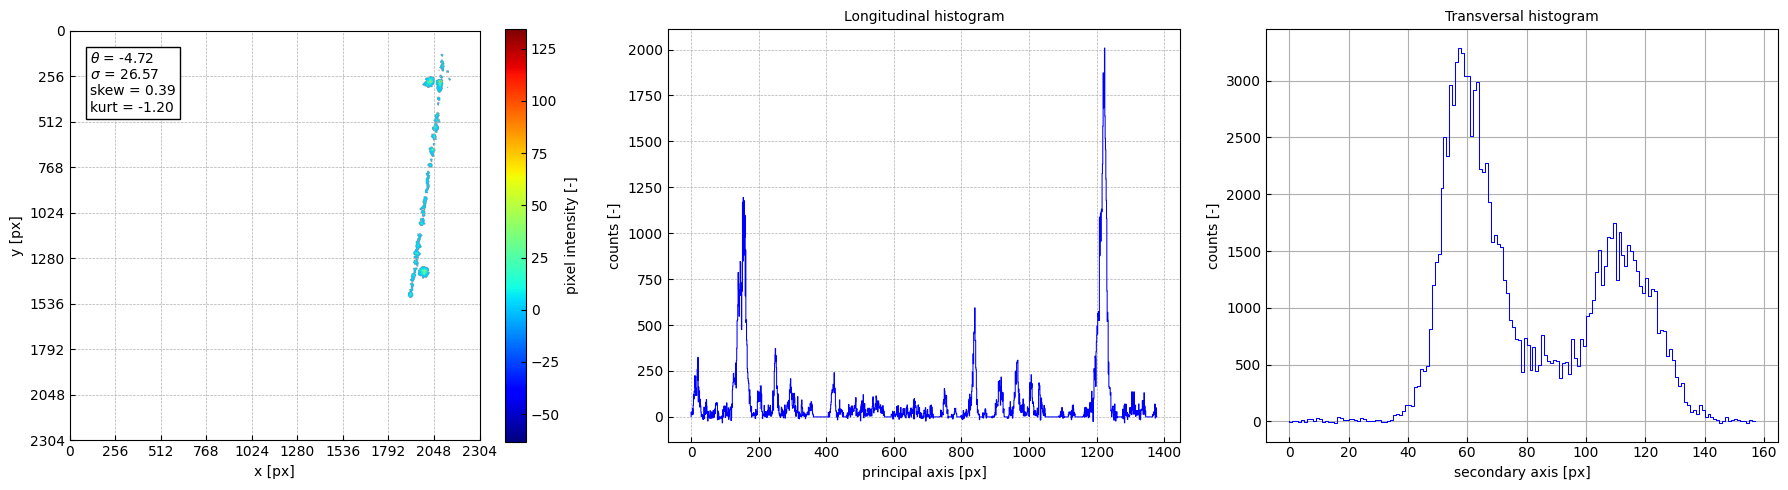

In [10]:
track.plot(0)

In [11]:
"""
Now onto the analysis of the high-level data extracted by means of track analysis
"""

track_data = track.get_data()
print(track_data[0].keys())

def histogram(data, key, Nbins=15):
    vec = []
    for entry in data:
        vec.append(entry[key])
    
    y, bins = np.histogram(vec, bins=Nbins)
    fig, ax = plt.subplots(figsize=(6,5))
    #ax.errorbar(bins[:-1], y, yerr=np.sqrt(y), marker='o', linestyle='', markersize=3, elinewidth=.7, color='black')
    ax.hist(vec, bins=Nbins, color='black', histtype='stepfilled', alpha=0.5)
    ax.grid(linewidth=.5, linestyle='--')
    ax.set_xlabel(key)
    ax.set_ylabel('Counts')
    plt.tight_layout()
    plt.show()

def correlation_plot(data, key1, key2):
    vec1 = []
    vec2 = []
    for entry in data:
        vec1.append(entry[key1])
        vec2.append(entry[key2])
        
    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(vec1, vec2, marker='o', s=2, color='black')
    ax.grid(linewidth=.5, linestyle='--')
    ax.set_xlabel(key1)
    ax.set_ylabel(key2)
    plt.tight_layout()
    plt.show()

#histogram(track_data, 'sc_tkurtosis', Nbins=50)
#correlation_plot(track_data, 'sc_length', 'sc_width')

dict_keys(['image_idx', 'cluster_idx', 'sc_length', 'sc_width', 'principal_axis', 'secondary_axis', 'sc_theta', 'sc_theta_fit', 'sc_linearity', 'sc_max_residual', 'm_fit', 'sc_tskewness', 'sc_tkurtosis', 'sc_tfullrms', 'center_coordinates', 'edge_origin', 'histl', 'stepl', 'histt', 'stept', 'proj_lon', 'proj_tra', 'redpix_ix', 'redpix_iy', 'redpix_iz'])


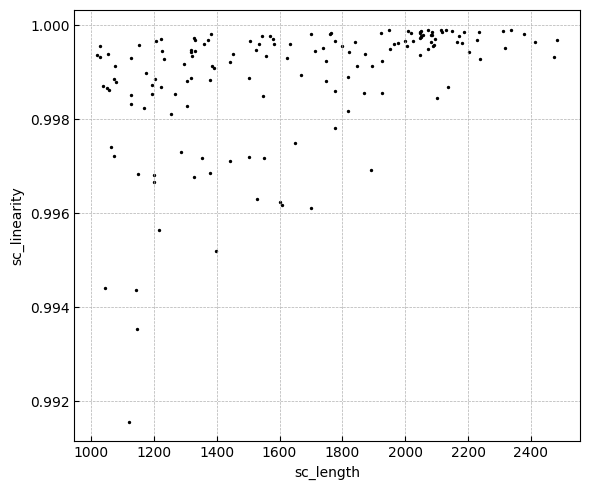

In [12]:
correlation_plot(track_data, 'sc_length', 'sc_linearity')

In [13]:
import numpy as np
import matplotlib.pyplot as plt

class HighLevelSelector:
    def __init__(self, track, wave, store_redpix=False, mask=False, pos=None, config_file="ConfigFile_dataprocess.txt"):
        self.track_analyzer = track
        self.wave = wave
        self.store_redpix = store_redpix
        self.pos = pos
        self.config = self._read_config(config_file)
        
        self.track_data = self._extract_track_data()
        
        if mask:
            self._mask = self._muon_mask_eval()
        else:
            self._mask = np.ones(len(self.track_data), dtype=bool)

    def _read_config(self, config_file):
        params = {}
        try:
            with open(config_file, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.split('=')
                        if len(parts) >= 2:
                            key = parts[0].strip()
                            value_str = "=".join(parts[1:]).strip()
                            try:
                                value = float(value_str)
                            except ValueError:
                                value = value_str
                            params[key] = value
        except FileNotFoundError:
            pass
        return params

    def _calculate_match_score(self, track_integral, track_x, pmt_data):
        if len(pmt_data['charge_pmt_1']) == 0:
            return 0.0, 0.0, 0.0

        q1_arr = np.array(pmt_data['charge_pmt_1'])
        q2_arr = np.array(pmt_data['charge_pmt_2'])
        
        calib = self.config.get('energy_calib', 500.0)
        sigma_e = self.config.get('energy_sigma', 0.5)
        
        pmt1_pos = str(self.config.get('pmt1_position', 'left')).lower()
        
        img_center = 1152.0
        norm_x = (track_x - img_center) / img_center
        sigma_pos = self.config.get('pos_sigma', 0.4)

        best_total = 0.0
        best_e = 0.0
        best_pos = 0.0

        for i in range(len(q1_arr)):
            q1 = q1_arr[i]
            q2 = q2_arr[i]
            q_tot = q1 + q2
            
            if q_tot <= 0:
                continue

            expected_integral = q_tot * calib
            denom = expected_integral * sigma_e if expected_integral > 0 else 1.0
            delta_e = (track_integral - expected_integral) / denom
            score_e = np.exp(-0.5 * delta_e**2)

            if pmt1_pos == 'left':
                asym = (q2 - q1) / q_tot
            else:
                asym = (q1 - q2) / q_tot
                
            delta_pos = (norm_x - asym) / sigma_pos
            score_pos = np.exp(-0.5 * delta_pos**2)

            total_score = score_e * score_pos
            
            if total_score > best_total:
                best_total = total_score
                best_e = score_e
                best_pos = score_pos
        
        return best_total, best_e, best_pos

    def _extract_track_data(self):
        raw_data = self.track_analyzer.get_data()
        
        keys_to_discard = []
        if not self.store_redpix:
            keys_to_discard = ['principal_axis', 'secondary_axis',
                               'edge_origin', 
                               'redpix_ix', 'redpix_iy', 'redpix_iz']
        
        if not raw_data:
            return []

        all_keys = raw_data[0].keys()
        kept_keys = [k for k in all_keys if k not in keys_to_discard and k != 'center_coordinates']
        
        data_list = []
        for t in raw_data:
            image_idx = t['image_idx']
            pmt_info = self.wave.get_data(image_idx)
            
            centroid_x = t['center_coordinates'][0]
            integral = t.get('sc_integral', 0)

            s_tot, s_e, s_pos = self._calculate_match_score(integral, centroid_x, pmt_info)

            temp = {key: t[key] for key in kept_keys}
            
            if 'center_coordinates' not in keys_to_discard:
                temp['center_coordinates'] = t['center_coordinates']

            temp['matching_score'] = s_tot
            temp['score_energy'] = s_e
            temp['score_pos'] = s_pos
            
            data_list.append(temp)
            
        return data_list

    def _muon_mask_eval(self):
        mask = []
        theta_cut_val = self.config.get('theta_cut', 40.0)
        z_window_val = self.config.get('z_window', 3.0)
        min_score_val = self.config.get('min_score', 0.0)

        for track in self.track_data:
            image_idx = track['image_idx']
            
            theta_condition = np.abs(track['sc_theta']) < theta_cut_val
            score_condition = track['matching_score'] >= min_score_val
            
            z_condition = True
            if self.pos is not None:
                pmt_info = self.wave.get_data(image_idx)
                z1 = np.array(pmt_info['z_coord_pmt_1'])
                z2 = np.array(pmt_info['z_coord_pmt_2'])
                
                upper_z = float(self.pos) + z_window_val
                lower_z = float(self.pos) - z_window_val
                
                z1_ok = np.all((z1 <= upper_z) & (z1 >= lower_z))
                z2_ok = np.all((z2 <= upper_z) & (z2 >= lower_z))
                
                z_condition = z1_ok & z2_ok

            mask.append(theta_condition & z_condition & score_condition)
            
        return np.array(mask)

    def get_data(self):
        return [d for d, m in zip(self.track_data, self._mask) if m]

    def plot_matches(self, image_index):
        if not self.store_redpix:
            print("Cannot plot: store_redpix is False")
            return

        tracks_in_image = [t for t in self.track_data if t['image_idx'] == image_index]
        
        if not tracks_in_image:
            print(f"No tracks found for image {image_index}")
            return

        fig, ax = plt.subplots(figsize=(5, 5))
        
        image_canvas = np.full((2304, 2304), np.nan)
        
        for track in tracks_in_image:
            x = track['redpix_ix'].astype(int)
            y = track['redpix_iy'].astype(int)
            z = track['redpix_iz']
            image_canvas[y, x] = z
            
        im = ax.imshow(image_canvas, cmap='jet', origin='upper')
        pmt_info = self.wave.get_data(image_index)
        q1_arr = np.array(pmt_info['charge_pmt_1'])
        q2_arr = np.array(pmt_info['charge_pmt_2'])
        
        if len(q1_arr) > 0:
            q_tot_arr = q1_arr + q2_arr
            best_pulse_idx = np.argmax(q_tot_arr)
            q1 = q1_arr[best_pulse_idx]
            q2 = q2_arr[best_pulse_idx]
            
            pmt1_pos = str(self.config.get('pmt1_position', 'left')).lower()
            
            if pmt1_pos == 'left':
                q_left = q1
                q_right = q2
            else:
                q_left = q2
                q_right = q1
                
            total_q = q_left + q_right
            if total_q > 0:
                asymmetry = (q_right - q_left) / total_q
                
                if asymmetry < 0: 
                    ax.axvspan(0, 1152, color='red', alpha=0.15, label='PMT Left Region')
                else: 
                    ax.axvspan(1152, 2304, color='red', alpha=0.15, label='PMT Right Region')

        for track in tracks_in_image:
            cx = track['center_coordinates'][0]
            cy = track['center_coordinates'][1]
            
            s_tot = track['matching_score']
            s_eng = track['score_energy']
            s_pos = track['score_pos']
            
            label = f"Tot: {s_tot:.2f}\nE: {s_eng:.2f}\nPos: {s_pos:.2f}"
            
            ax.text(cx, cy, label, color='white', fontsize=9, 
                    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'),
                    ha='center', va='center')

        ax.set_title(f"Image {image_index} - Matching Scores")
        ax.set_xlabel("x [px]")
        ax.set_ylabel("y [px]")
        ax.grid(linewidth=0.5, linestyle='--')
        plt.tight_layout()
        plt.show()

In [14]:
sel = HighLevelSelector(track, wave, store_redpix=True, mask=True, pos=None, config_file="ConfigFile_DataProcess.txt")
sel_data = sel.get_data()

In [15]:
print(sel_data[0].keys())

dict_keys(['image_idx', 'cluster_idx', 'sc_length', 'sc_width', 'principal_axis', 'secondary_axis', 'sc_theta', 'sc_theta_fit', 'sc_linearity', 'sc_max_residual', 'm_fit', 'sc_tskewness', 'sc_tkurtosis', 'sc_tfullrms', 'edge_origin', 'histl', 'stepl', 'histt', 'stept', 'proj_lon', 'proj_tra', 'redpix_ix', 'redpix_iy', 'redpix_iz', 'center_coordinates', 'matching_score', 'score_energy', 'score_pos'])


In [16]:
for image in range(1):
    sel.plot_matches(image)

No tracks found for image 0


In [96]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

class MuonAnalyzer:
    def __init__(self, tracks, step, min_light):
        self.tracks = tracks
        self.step = int(step)
        self.min_light = float(min_light)
        self.data = self._transversal_analyser()

    def _subclu_finder(self, x, y):
        x_start = []
        x_end = []
        idx_start = []
        idx_end = []
        n_clust = 0
        clust_int = []
        
        width = np.diff(x)
        width = np.append(width, width[-1])
        
        searching = True
        
        for xbin in range(len(y)):
            if (searching) and (y[xbin] >= self.min_light):
                idx_start.append(xbin)
                if xbin == 0:
                    x_start.append(x[xbin])
                else:
                    x_start.append(x[xbin-1])
                
                integral = 0
                searching = False
                
            if not searching:
                integral += width[xbin]*y[xbin]
                
            if (not searching) and (y[xbin] <= self.min_light):
                if (xbin < len(y)-4):
                    if np.all(y[xbin:xbin + 3] <= self.min_light):
                        idx_end.append(xbin)
                        x_end.append(x[xbin])
                        n_clust += 1
                        clust_int.append(integral)
                        searching = True
    
        if not searching:
            idx_end.append(len(y))
            x_end.append(x[-1])
            clust_int.append(integral)
            n_clust += 1
            
        return np.array(x_start), np.array(x_end), np.array(idx_start), np.array(idx_end), np.array(clust_int), n_clust

    def _equal_slicer(self, y):
        n_steps = len(y) // self.step
        if n_steps == 0:
            return np.array([])
            
        y_trunc = y[:n_steps * self.step]
        slices = y_trunc.reshape(n_steps, self.step).sum(axis=1)
        
        return slices

    def _transversal_analyser(self):
        data = []

        for track in self.tracks.get_data():
            hist = track['histl']
            coords = track['stepl']
            
            x_s, x_e, idx_s, idx_e, clu_int, n_clu = self._subclu_finder(coords, hist)
            
            inclu_slices_list = []
            for i in range(len(idx_s)):
                sub_y = hist[idx_s[i]:idx_e[i]]
                slices = self._equal_slicer(sub_y)
                if len(slices) > 0:
                    inclu_slices_list.append(slices)
            
            if len(inclu_slices_list) > 0:
                equal_inclu_slices = np.concatenate(inclu_slices_list)
            else:
                equal_inclu_slices = np.array([])
            
            equal_slices = self._equal_slicer(hist)

            track_dict = {
                'starts': x_s,
                'ends': x_e,
                'widths': x_e - x_s,
                'cluster_integrals': clu_int,
                'n_clusters': n_clu,
                'equal_inclu_slices': np.array(equal_inclu_slices),
                'equal_slices': np.array(equal_slices)
            }
            
            data.append(track_dict)

        return data

    def get_data(self):
        return self.data

    def plot_highlighted_clusters(self, index, start=None, end=None):
        raw_tracks = self.tracks.get_data()
        
        if 0 <= index < len(self.data):
            fig, ax = plt.subplots(figsize=(10, 6))
            
            hist = raw_tracks[index]['histl']
            steps = raw_tracks[index]['stepl']
            
            ax.step(steps, hist, color='black', linewidth=.75, where='mid')
            
            cluster_starts = self.data[index]['starts']
            cluster_ends = self.data[index]['ends']

            for j in range(len(cluster_starts)):
                ax.axvspan(cluster_starts[j], cluster_ends[j], color='blue', alpha=0.2)
            
            ax.set_title(f'Longitudinal histogram (Track {index})')
            ax.set_xlabel('principal axis [px]')
            ax.set_ylabel('counts [-]')
            
            start_idx = np.min(steps)
            end_idx = np.max(steps)
            
            if start is not None:
                start_idx = max(start_idx, start)
            if end is not None:
                end_idx = min(end_idx, end)
            
            ax.set_xlim(start_idx, end_idx)
            ax.grid(linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()
        else:
            print(f'Invalid index range, index must be between 0 and {len(self.data)}')

In [112]:
mu = MuonAnalyzer(sel, step=16, min_light=2)
mu_data = mu.get_data()

In [113]:
print(mu_data[0].keys())

def histogram(data, key, Nbins=50, max_clamp=1e4):
    vec = []
    for entry in data:
        vec.append(entry[key])

    vec = np.concatenate(vec)
    print(len(vec))

    cut = (vec <= max_clamp)
    y, bins = np.histogram(vec[cut], Nbins)
    dx = (bins[1] - bins[0])/2
    x = bins[:-1] + dx
    
    fig, ax = plt.subplots(figsize=(6,5))
    ax.errorbar(x, y, yerr=np.sqrt(y), marker='o', color='black', elinewidth=0.5, linestyle='', markersize=3)
    ax.set_ylabel('Counts')
    ax.set_xlabel(key)
    ax.grid(linewidth=.5, linestyle='--')
    plt.show()

dict_keys(['starts', 'ends', 'widths', 'cluster_integrals', 'n_clusters', 'equal_inclu_slices', 'equal_slices'])


13082


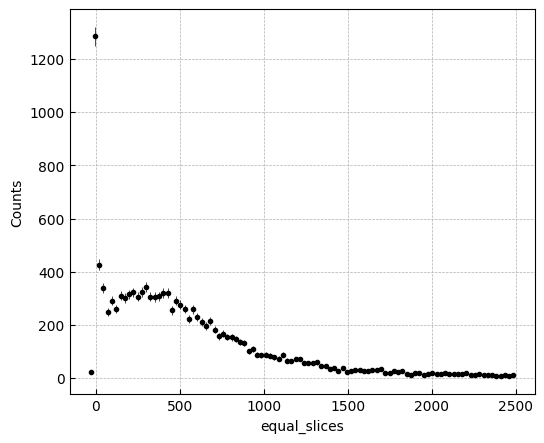

In [127]:
histogram(mu_data, 'equal_slices', Nbins=100, max_clamp=2.5e3)

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

class TrackAssociator:
    def __init__(self, tracks, subclu):
        self.tracks = tracks
        self.subclu = subclu

    def get_associated_data(self, index):
        track_data = self.tracks.get_data()
        muon_data = self.subclu.get_data()
        
        if index < 0 or index >= len(track_data):
            return []

        t_entry = track_data[index]
        m_entry = muon_data[index]

        rx = t_entry['redpix_ix']
        ry = t_entry['redpix_iy']
        rz = t_entry['redpix_iz']
        
        centroid = np.array(t_entry['edge_origin'])
        p_axis = np.array(t_entry['principal_axis'])
        s_axis = np.array(t_entry['secondary_axis'])
        
        width_cut = t_entry['sc_width']

        pixels = np.column_stack((rx, ry))
        vecs = pixels - centroid
        
        long_proj = vecs @ p_axis
        trans_proj = vecs @ s_axis
        
        starts = m_entry['starts']
        ends = m_entry['ends']
        integrals = m_entry['cluster_integrals']
        
        clusters = []

        for i in range(len(starts)):
            s = starts[i]
            e = ends[i]
            
            l_mask = (long_proj >= s) & (long_proj <= e)
            t_mask = np.abs(trans_proj) <= width_cut
            
            combined_mask = l_mask & t_mask
            
            cluster_dict = {
                'rx': rx[combined_mask],
                'ry': ry[combined_mask],
                'rz': rz[combined_mask],
                'integral': integrals[i],
                'start': s,
                'end': e
            }
            clusters.append(cluster_dict)
            
        return clusters

    def plot_track(self, index):
        track_data = self.tracks.get_data()
        if index < 0 or index >= len(track_data):
            print(f"Index {index} out of range")
            return

        t_entry = track_data[index]
        rx = t_entry['redpix_ix']
        ry = t_entry['redpix_iy']
        rz = t_entry['redpix_iz']
        
        centroid = np.array(t_entry['edge_origin'])
        p_axis = np.array(t_entry['principal_axis'])
        s_axis = np.array(t_entry['secondary_axis'])
        width = t_entry['sc_width']
        
        clusters = self.get_associated_data(index)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        ax.scatter(rx, ry, s=1, c='lightgrey', alpha=0.5, label='Track Pixels')
        
        cmap = plt.get_cmap('jet')
        n_clu = len(clusters)
        
        for i, clu in enumerate(clusters):
            color = cmap(i / max(1, n_clu))
            ax.scatter(clu['rx'], clu['ry'], s=2, color=color, label=f'Cluster {i}')
            
            s = clu['start']
            e = clu['end']
            
            p1 = centroid + s * p_axis - width * s_axis
            p2 = centroid + s * p_axis + width * s_axis
            p3 = centroid + e * p_axis + width * s_axis
            p4 = centroid + e * p_axis - width * s_axis
            
            poly = Polygon([p1, p2, p3, p4], closed=True, 
                           edgecolor=color, facecolor=color, alpha=0.1, linewidth=1.5)
            ax.add_patch(poly)

        t_vals = np.linspace(np.min(t_entry['stepl']), np.max(t_entry['stepl']), 10)
        spine = centroid + np.outer(t_vals, p_axis)
        ax.plot(spine[:, 0], spine[:, 1], 'k--', linewidth=1, label='Principal Axis')

        ax.set_title(f"Track {index} - 2D Association")
        ax.set_xlabel("x [px]")
        ax.set_ylabel("y [px]")
        ax.set_aspect('equal')
        ax.legend()
        ax.grid(linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

    def plot_cluster(self, index, cluster_id):
        clusters = self.get_associated_data(index)
        
        if cluster_id < 0 or cluster_id >= len(clusters):
            print(f"Cluster {cluster_id} not found in track {index}")
            return
            
        clu = clusters[cluster_id]
        
        fig, ax = plt.subplots(figsize=(6, 6))
        
        sc = ax.scatter(clu['rx'], clu['ry'], c=clu['rz'], cmap='jet', s=10)
        plt.colorbar(sc, ax=ax, label='Charge [ADU]')
        
        ax.set_title(f"Track {index} | Cluster {cluster_id}")
        ax.set_xlabel("x [px]")
        ax.set_ylabel("y [px]")
        ax.set_aspect('equal')
        ax.grid(linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()

In [129]:
ass = TrackAssociator(sel, mu)

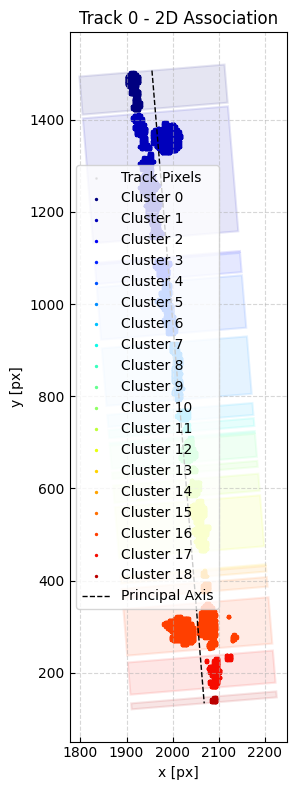

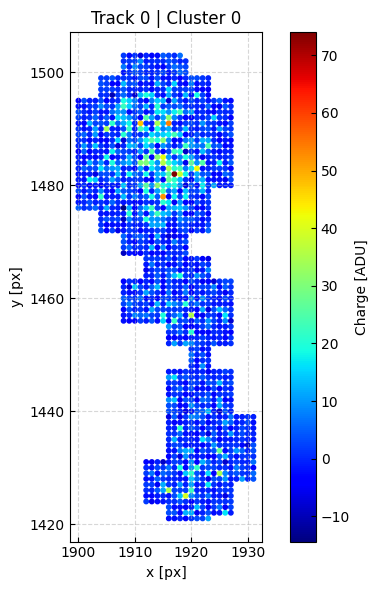

In [131]:
ass.plot_track(0)
ass.plot_cluster(0, 0)